# Pratices

Try to modify the `cel_size`, `num_cells_per_block` and `num_bins` to see how they affect HOG.
There is a total of 12 images in the image folder to test.


Gray image shape: (424, 640)

HOG Descriptor Params:

Window size: (640, 424)

Cell size: (8, 8)

Block size: (16, 16)

Block stride: (8, 8)

Number of bins: 9



<IPython.core.display.Javascript object>


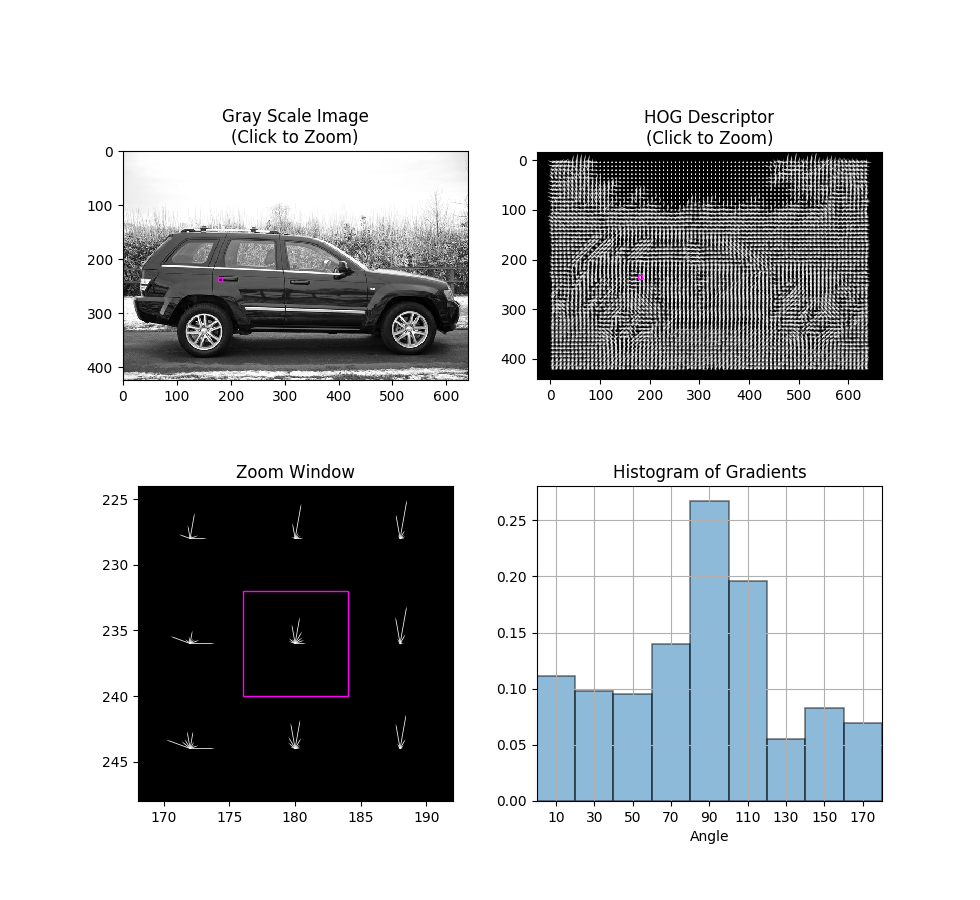

In [6]:
%matplotlib notebook
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams["figure.figsize"] = [9.8, 9]

image = cv2.imread("images/jeep2.jpeg")

cell_size = (8, 8)
num_cells_per_block = (2, 2)
num_bins = 9

original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

block_size = (num_cells_per_block[0] * cell_size[0], 
              num_cells_per_block[1] * cell_size[1])

x_cells = gray_image.shape[1] // cell_size[0]
y_cells = gray_image.shape[0] // cell_size[1]

h_stride = 1
v_stride = 1

block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

win_size = (x_cells * cell_size[0], y_cells * cell_size[1])

print("""
Gray image shape: {}\n
HOG Descriptor Params:\n
Window size: {}\n
Cell size: {}\n
Block size: {}\n
Block stride: {}\n
Number of bins: {}
""" .format(gray_image.shape, win_size, cell_size, block_size, block_stride, num_bins))

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
hog_descriptor = hog.compute(gray_image)

tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)
tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins

# Reshape to match the indexes
hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx, tot_by, num_cells_per_block[0], num_cells_per_block[1],
                                          num_bins).transpose((1, 0, 2, 3, 4))

ave_grad = np.zeros((y_cells, x_cells, num_bins))
hist_counter = np.zeros((y_cells, x_cells, 1))

# Add all hist for each cell and count the number of hist per cell

for i in range(num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

# Average gradient
ave_grad /= hist_counter

len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

deg = np.linspace(0, np.pi, num_bins, endpoint = False)

U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the 
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

# Create the bins in degress to plot our histogram. 
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

# Create a figure with 4 subplots arranged in 2 x 2
fig, ((a,b),(c,d)) = plt.subplots(2,2)

# Set the title of each subplot
a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

# Plot the gray scale image
a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plot the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

# Define function for interactive zoom
def onpress(event):
    
    #Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Create a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        # A single patch can only be used in a single plot. Create copies
        # of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        # Update all subplots
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_image, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

# Create a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()






























